In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("/content/drive/My Drive/CSMP-Project")

Mounted at /content/drive


In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

!pip install matplotlib -q --upgrade

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from keras import layers

In [3]:
data_file = 'data/HertzianContact/dataWithLabelled.csv'

column_names = ['radius Curvature', 'surface Energy', 'pulloff Force']

data = pd.read_csv(data_file)
data.head()

,radius Curvature,surface Energy,pulloff Force
0,8.826360e-07,0.013163,5.474700e-08
1,7.556060e-02,0.045870,1.633310e-02
2,5.327680e-02,0.021904,5.499170e-03
3,4.704560e-03,0.067890,1.505090e-03
4,6.792970e-02,0.093470,2.992080e-02


In [ ]:
dataset = data.copy()
dataset.tail()

,radius Curvature,surface Energy,pulloff Force
995,0.003038,0.058216,0.000833
996,0.064165,0.015514,0.004691
997,0.006826,0.030759,0.000989
998,0.057431,0.036867,0.009978
999,0.021003,0.003507,0.000347


In [ ]:
train_dataset = dataset.sample(frac=0.85, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

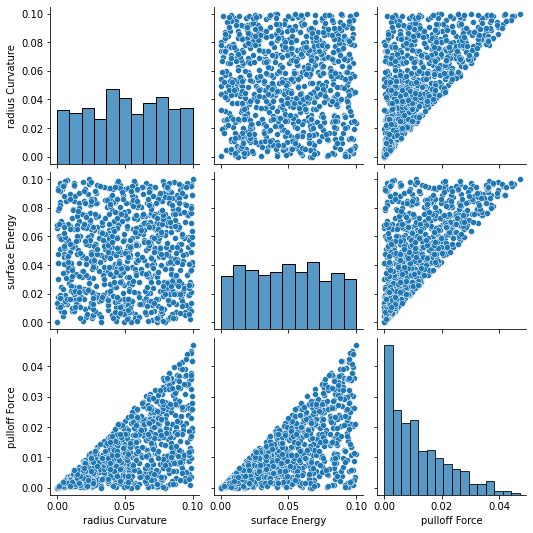

In [ ]:
sns.pairplot(train_dataset[['radius Curvature', 'surface Energy', 'pulloff Force']])

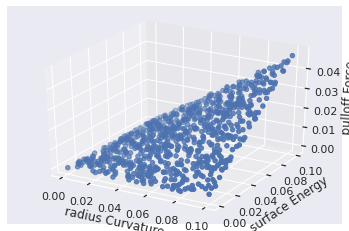

In [ ]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = train_dataset['radius Curvature']
y = train_dataset['surface Energy']
z = train_dataset['pulloff Force']

ax.set_xlabel("radius Curvature")
ax.set_ylabel("surface Energy")
ax.set_zlabel("pulloff Force")

ax.scatter(x, y, z)

plt.show()

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('pulloff Force')
test_labels = test_features.pop('pulloff Force')

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
radius Curvature,0.051010,0.028462
surface Energy,0.049118,0.028054
pulloff Force,0.011802,0.010218


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[0.05101043 0.04911796]]


In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(256, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(128, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(1e-4))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_44 (Dense)            (None, 512)               1536      
                                                                 
 batch_normalization_35 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_35 (Dropout)        (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_36 (Bat  (None, 512)             

In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    batch_size=200,
    validation_split=0.2,
    epochs=2000)

Epoch 1/2000
4/4 [==============================] - 2s 85ms/step - loss: 1.5473 - val_loss: 0.0149
Epoch 2/2000
4/4 [==============================] - 0s 26ms/step - loss: 1.5307 - val_loss: 0.0143
Epoch 3/2000
4/4 [==============================] - 0s 26ms/step - loss: 1.5085 - val_loss: 0.0116
Epoch 4/2000
4/4 [==============================] - 0s 25ms/step - loss: 1.5180 - val_loss: 0.0122
Epoch 5/2000
4/4 [==============================] - 0s 31ms/step - loss: 1.4587 - val_loss: 0.0162
Epoch 6/2000
4/4 [==============================] - 0s 26ms/step - loss: 1.4405 - val_loss: 0.0206
Epoch 7/2000
4/4 [==============================] - 0s 30ms/step - loss: 1.5186 - val_loss: 0.0313
Epoch 8/2000
4/4 [==============================] - 0s 27ms/step - loss: 1.5221 - val_loss: 0.0377
Epoch 9/2000
4/4 [==============================] - 0s 32ms/step - loss: 1.4515 - val_loss: 0.0388
Epoch 10/2000
4/4 [==============================] - 0s 27ms/step - loss: 1.4659 - val_loss: 0.0397
Epoch 11/

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,10))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [pulloff Force]')
  plt.legend()
  plt.grid(True)

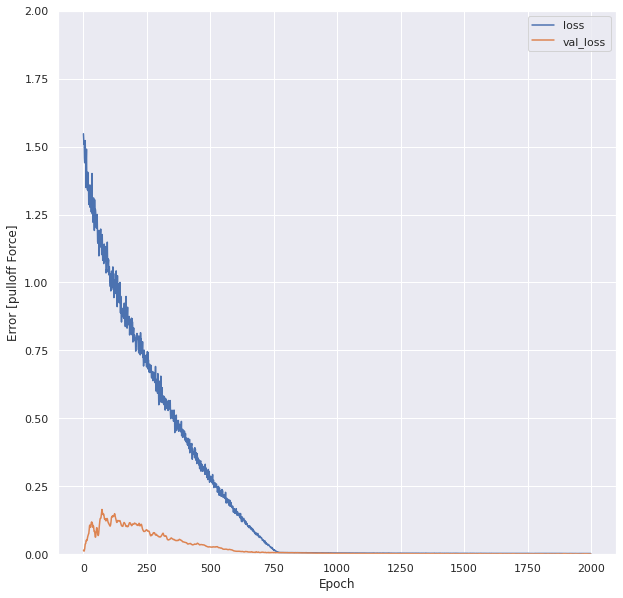

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels)

5/5 [==============================] - 0s 3ms/step - loss: 0.0013


In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [pulloff Force]']).T

,Mean absolute error [pulloff Force]
dnn_model,0.001264


5/5 [==============================] - 0s 3ms/step


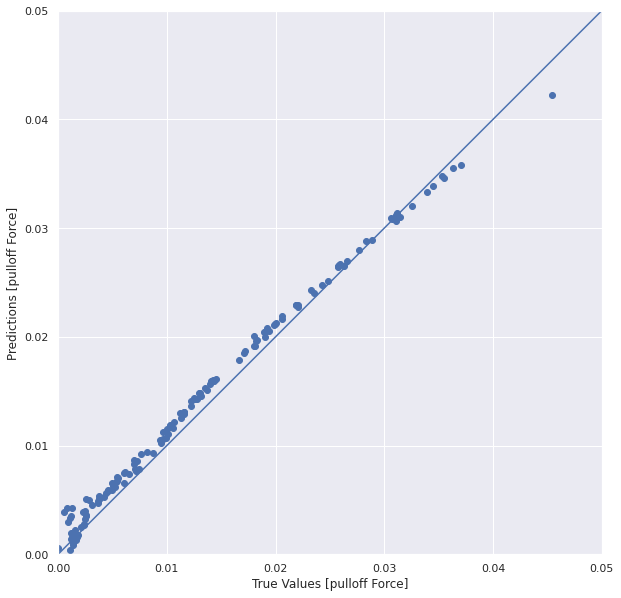

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

plt.figure(figsize=(10,10))
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pulloff Force]')
plt.ylabel('Predictions [pulloff Force]')
lims = [0, 0.05]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

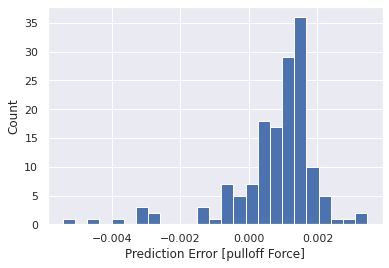

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [pulloff Force]')
_ = plt.ylabel('Count')